In [29]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from celluloid import Camera
from IPython.display import HTML

In [14]:
root = Path('../Datasets/Task02_Heart/imagesTr/')
labels = Path('../Datasets/Task02_Heart/labelsTr/')

In [17]:
Path(*root.parts)

PosixPath('../Datasets/Task02_Heart/imagesTr')

In [18]:
def change_to_label_path(path):
    
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [24]:
sample_path = list(root.glob('la*'))[0]
sample_path

PosixPath('../Datasets/Task02_Heart/imagesTr/la_011.nii.gz')

In [25]:
sample_path_label = change_to_label_path(sample_path)
sample_path_label

PosixPath('../Datasets/Task02_Heart/labelsTr/la_011.nii.gz')

In [27]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [28]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

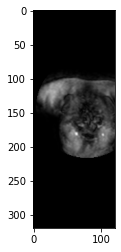

In [37]:
fig = plt.figure()
cam = Camera(fig)

for i in range(mri.shape[1]):
    plt.imshow(mri[:, i, :], cmap='gray')
    mask_ = np.ma.masked_where(mask[:, i, :]==0, mask[:, i, :])
    plt.imshow(mask_, alpha=0.7, cmap='autumn')
    cam.snap()
    
animation = cam.animate()

In [38]:
HTML(animation.to_html5_video())

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


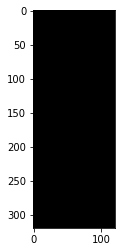

In [39]:
fig = plt.figure()
cam = Camera(fig)

for i in range(mri.shape[0]):
    plt.imshow(mri[i, :, :], cmap='gray')
    mask_ = np.ma.masked_where(mask[i, :, :]==0, mask[i, :, :])
    plt.imshow(mask_, alpha=0.7, cmap='autumn')
    cam.snap()
    
animation = cam.animate()

In [40]:
HTML(animation.to_html5_video())

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


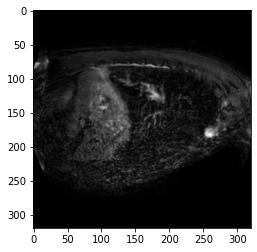

In [41]:
fig = plt.figure()
cam = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:, :, i], cmap='gray')
    mask_ = np.ma.masked_where(mask[:, :, i]==0, mask[:, :, 1])
    plt.imshow(mask_, alpha=0.7, cmap='autumn')
    cam.snap()
    
animation = cam.animate()

In [42]:
HTML(animation.to_html5_video())

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2
